# Advanced dynamic seq2seq with TensorFlow

# 用tensorflow实现的高级动态seq2seq

Encoder is bidirectional now. Decoder is implemented using `tf.nn.raw_rnn`. It feeds previously generated tokens during training as inputs, instead of target sequence.

编码器现在是双向的。解码器使用`tf.nn.raw_rnn`实现。 它在训练期间将以前生成的tokens作为输入，而不是目标序列。

regular seq2seq 常规seq2seq

![seq2seq architecutre](pictures/1-seq2seq.png)

Rectangles are encoder and decoder's recurrent layers. Encoder receives `[A, B, C]` sequence as inputs. We don't care about encoder outputs, only about the hidden state it accumulates while reading the sequence. After input sequence ends, encoder passes its final state to decoder, which receives `[<EOS>, W, X, Y, Z]` and is trained to output `[W, X, Y, Z, <EOS>]`. `<EOS>` token is a special word in vocabulary that signals to decoder the beginning of translation.

矩形是编码器和解码器的循环层。 编码器接收`[A，B，C]`序列作为输入。 我们不关心编码器输出，只关于读取序列时积累的隐藏状态。在输入序列结束后，编码器将其最终状态传递给解码器，解码器接收`[<EOS>，W，X，Y，Z]`，并经过训练以输出`[W，X，Y，Z，<EOS>]`。 `<EOS>`token是词汇中的一个特殊单词，用于指示解码器的翻译开始。

## Implementation details 实现细节

TensorFlow has its own [implementation of seq2seq](https://www.tensorflow.org/tutorials/seq2seq/). Recently it was moved from core examples to [`tensorflow/models` repo](https://github.com/tensorflow/models/tree/master/tutorials/rnn/translate), and uses deprecated seq2seq implementation. Deprecation happened because it uses **static unrolling**. 

tensorflow有它自己的 [seq2seq实现](https://www.tensorflow.org/tutorials/seq2seq/)。最近它转移到了核心例程  [`tensorflow/models` repo](https://github.com/tensorflow/models/tree/master/tutorials/rnn/translate)，并使用不推荐使用的seq2seq实现，因为使用 **静态展开**，所以不推荐使用。

**Static unrolling** involves construction of computation graph with a fixed sequence of time step. Such a graph can only handle sequences of specific lengths. One solution for handling sequences of varying lengths is to create multiple graphs with different time lengths and separate the dataset into this buckets.

**静态展开** 涉及用固定的时间步长构建计算图。 这样的图形只能处理特定长度的序列。 而处理不同长度的序列的解决方案是创建具有不同时间长度的多个图形，并将数据集分成此存储桶。

**Dynamic unrolling** instead uses control flow ops to process sequence step by step. In TF this is supposed to more space efficient and just as fast. This is now a recommended way to implement RNNs.

**动态展开** 代替使用控制流操作来逐步处理序列。 在TF中，这应该具有更高的空间效率，同样快。 现在是实施RNN的推荐方法。

In [2]:
#we give encoder input sequence like 'hello how are you', we take the last hidden state and feed to decoder and it
#will generate a decoded value. we compare that to target value, if translation would be 'bonjour ca va' and minimize 
#the difference by optimizing a loss function
# 我们给编码器输入序列像'hello how are you'，我们把最后一个隐藏的状态提供给解码器，它会产生一个解码的值。 
# 我们将其与目标值进行比较，如果翻译将是‘bonjour ca va’，并通过优化损失函数来最小化差异

#in this case we just want to encode and decode the input successfully
# 在这种情况下，我们只想对输入进行编码和解码

#bidirectional encoder 双向编码器
#We will teach our model to memorize and reproduce input sequence. 
#Sequences will be random, with varying length.
#Since random sequences do not contain any structure, model will not be able to exploit any patterns in data. 
#It will simply encode sequence in a thought vector, then decode from it.
#this is not about prediction (end goal), it's about understanding this architecture
#我们将教我们的模型来记忆和再现输入序列。
#Sequences将是随机的，长度不同。
#因为随机序列不包含任何结构，模型将无法利用数据中的任何模式。
#它将简单地在一个思想向量中编码序列，然后从它解码。
#这不是关于预测（最终目标），而是关于理解这个架构

#this is an encoder-decoder architecture. The encoder is bidrectional so 
#it It feeds previously generated tokens during training as inputs, instead of target sequence.
#这是一个编码器 - 解码器架构。 编码器是双向的，因此它在训练期间将以前生成的token作为输入，而不是目标序列。

import numpy as np #matrix math 
import tensorflow as tf #machine learningt
import helpers #for formatting data into batches and generating random sequence data

tf.reset_default_graph() #Clears the default graph stack and resets the global default graph.
sess = tf.InteractiveSession() #initializes a tensorflow session

ImportError: No module named tensorflow

In [2]:
tf.__version__

'1.0.1'

In [3]:
#First critical thing to decide: vocabulary size.
#Dynamic RNN models can be adapted to different batch sizes 
#and sequence lengths without retraining 
#(e.g. by serializing model parameters and Graph definitions via tf.train.Saver), 
#but changing vocabulary size requires retraining the model.
#决定第一关键事项：词汇大小。
#动态RNN模型可以适应不同的批量大小和序列长度，而无需重新训练(例如通过串行化模型参数和通过tf.train.Saver绘制图形定义)
#但是改变词汇大小需要重新训练模型。

PAD = 0
EOS = 1

vocab_size = 10
input_embedding_size = 20 #character length

encoder_hidden_units = 20 #num neurons
decoder_hidden_units = encoder_hidden_units * 2 #in original paper, they used same number of neurons for both encoder
#and decoder, but we use twice as many so decoded output is different, the target value is the original input 
#in this example
# 在原始文件中，它们对于编码器和解码器都使用相同数量的神经元，但是我们使用的两倍的解码输出是不同的，目标值是本示例中的原始输入

Nice way to understand complicated function is to study its signature - inputs and outputs. With pure functions, only inputs-output relation matters.

理解复杂功能的好方法是研究其签名 - 输入和输出。 纯粹的功能来说，只有输入输出关系才是重要的。

- `encoder_inputs` int32 tensor is shaped `[encoder_max_time, batch_size]`
- `decoder_targets` int32 tensor is shaped `[decoder_max_time, batch_size]`

In [5]:
#input placehodlers
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')

#contains the lengths for each of the sequence in the batch, we will pad so all the same
#if you don't want to pad, check out dynamic memory networks to input variable length sequences
encoder_inputs_length = tf.placeholder(shape=(None,), dtype=tf.int32, name='encoder_inputs_length')
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')

 Here we implement decoder with `tf.nn.raw_rnn` and will construct `decoder_inputs` step by step in the loop.
 
 这里我们用`tf.nn.raw_rnn`实现解码器，并在循环中逐步构造`decode_inputs`。

### Embeddings 嵌入

`encoder_inputs` and `decoder_inputs` are int32 tensors of shape `[max_time, batch_size]`, while encoder and decoder RNNs expect dense vector representation of words, `[max_time, batch_size, input_embedding_size]`. We convert one to another by using *word embeddings*. Specifics of working with embeddings are nicely described in [official tutorial on embeddings](https://www.tensorflow.org/tutorials/word2vec/).

`encoder_inputs`和`decode_inputs`是形状为`[max_time，batch_size]`的int32张量，而编码器和解码器RNN则期望dense vector表示多个单词，`[max_time，batch_size，input_embedding_size]`。 我们通过使用 *字嵌入* 来转换另一个。 嵌入工作的具体内容在 [官方教程教程](https://www.tensorflow.org/tutorials/word2vec/) 中有很好的描述。

First we initialize embedding matrix. Initializations are random. We rely on our end-to-end training to learn vector representations for words jointly with encoder and decoder.

首先我们初始化嵌入矩阵。 初始化是随机的。 我们依靠我们的端到端训练来学习矢量表示在编码器和解码器中的单词

In [6]:
#randomly initialized embedding matrrix that can fit input sequence
#used to convert sequences to vectors (embeddings) for both encoder and decoder of the right size
#reshaping is a thing, in TF you gotta make sure you tensors are the right shape (num dimensions)
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype=tf.float32)

#this thing could get huge in a real world application
encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)

We use `tf.nn.embedding_lookup` to *index embedding matrix*: given word `4`, we represent it as 4th column of embedding matrix. 
This operation is lightweight, compared with alternative approach of one-hot encoding word `4` as `[0,0,0,1,0,0,0,0,0,0]` (vocab size 10) and then multiplying it by embedding matrix.

我们使用`tf.nn.embedding_lookup`到 *索引嵌入矩阵*：给定的单词`4`，我们将其表示为第4列的嵌入矩阵。
这个操作是轻量级的，与 One-Hot编码的“4”的替代方法相比，`[0,0,0,1,0,0,0,0,0,0]`(vocab size 10)，然后乘以 它通过嵌入矩阵。

Additionally, we don't need to compute gradients for any columns except 4th.

另外，除了4th之外，我们不需要计算任何列的渐变。

In real NLP application embedding matrix can get very large, with 100k or even 1m columns.

在实际的NLP应用中，嵌入矩阵可以获得非常大的，具有100k甚至1m的列。

## Encoder 编码器

We are replacing unidirectional `tf.nn.dynamic_rnn` with `tf.nn.bidirectional_dynamic_rnn` as the encoder.

我们用`tf.nn.bidirectional_dynamic_rnn`替代单向`tf.nn.dynamic_rnn`作为编码器。

In [7]:
from tensorflow.python.ops.rnn_cell import LSTMCell, LSTMStateTuple

ImportError: No module named 'tensorflow.python.ops.rnn_cell'

In [11]:
encoder_cell = LSTMCell(encoder_hidden_units)

In [13]:
#get outputs and states
#bidirectional RNN function takes a separate cell argument for 
#both the forward and backward RNN, and returns separate 
#outputs and states for both the forward and backward RNN

#When using a standard RNN to make predictions we are only taking the “past” into account. 
#For certain tasks this makes sense (e.g. predicting the next word), but for some tasks 
#it would be useful to take both the past and the future into account. Think of a tagging task, 
#like part-of-speech tagging, where we want to assign a tag to each word in a sentence. 
#Here we already know the full sequence of words, and for each word we want to take not only the 
#words to the left (past) but also the words to the right (future) into account when making a prediction. 
#Bidirectional RNNs do exactly that. A bidirectional RNN is a combination of two RNNs – one runs forward from 
#“left to right” and one runs backward from “right to left”. These are commonly used for tagging tasks, or 
#when we want to embed a sequence into a fixed-length vector (beyond the scope of this post).


((encoder_fw_outputs,
  encoder_bw_outputs),
 (encoder_fw_final_state,
  encoder_bw_final_state)) = (
    tf.nn.bidirectional_dynamic_rnn(cell_fw=encoder_cell,
                                    cell_bw=encoder_cell,
                                    inputs=encoder_inputs_embedded,
                                    sequence_length=encoder_inputs_length,
                                    dtype=tf.float64, time_major=True)
    )

ValueError: Variable BiRNN_FW/LSTMCell/W_0 already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "<ipython-input-12-4a02fa6316cc>", line 9, in <module>
    dtype=tf.float32, time_major=True)
  File "/Users/sraval/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/Users/sraval/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):


In [9]:
encoder_fw_outputs

<tf.Tensor 'bidirectional_rnn/fw/fw/TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 20) dtype=float32>

In [10]:
encoder_bw_outputs

<tf.Tensor 'ReverseSequence:0' shape=(?, ?, 20) dtype=float32>

In [11]:
encoder_fw_final_state

LSTMStateTuple(c=<tf.Tensor 'bidirectional_rnn/fw/fw/while/Exit_2:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'bidirectional_rnn/fw/fw/while/Exit_3:0' shape=(?, 20) dtype=float32>)

In [12]:
encoder_bw_final_state

LSTMStateTuple(c=<tf.Tensor 'bidirectional_rnn/bw/bw/while/Exit_2:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'bidirectional_rnn/bw/bw/while/Exit_3:0' shape=(?, 20) dtype=float32>)

Have to concatenate forward and backward outputs and state. In this case we will not discard outputs, they would be used for attention.

必须连接前后输出和状态。 在这种情况下，我们不会丢弃输出，它们将被用于引起注意。

In [13]:
#Concatenates tensors along one dimension.
encoder_outputs = tf.concat((encoder_fw_outputs, encoder_bw_outputs), 2)

#letters h and c are commonly used to denote "output value" and "cell state". 
#http://colah.github.io/posts/2015-08-Understanding-LSTMs/ 
#Those tensors represent combined internal state of the cell, and should be passed together. 

encoder_final_state_c = tf.concat(
    (encoder_fw_final_state.c, encoder_bw_final_state.c), 1)

encoder_final_state_h = tf.concat(
    (encoder_fw_final_state.h, encoder_bw_final_state.h), 1)

#TF Tuple used by LSTM Cells for state_size, zero_state, and output state.
encoder_final_state = LSTMStateTuple(
    c=encoder_final_state_c,
    h=encoder_final_state_h
)

## Decoder 解码器

In [14]:
decoder_cell = LSTMCell(decoder_hidden_units)

Time and batch dimensions are dynamic, i.e. they can change in runtime, from batch to batch When decoding, feeding previously generated tokens as inputs adds robustness to model's errors. However feeding ground truth speeds up training. Apperantly best practice is to mix both randomly when training.

时间和批量维度是动态的，即它们可以在运行时间内批量更改。当解码时，将以前生成的token作为输入，增加了模型错误的鲁棒性。 然而，喂养地面的真相加速了培训。 最佳练习是训练时随机混合。


In [15]:
#we could print this, won't need
encoder_max_time, batch_size = tf.unstack(tf.shape(encoder_inputs))

Next we need to decide how far to run decoder. There are several options for stopping criteria:

接下来我们需要决定运行解码器多久。 有几个停止条件的选项：

- Stop after specified number of unrolling steps  在具体数量的展开步骤后停止
- Stop after model produced <EOS> token  模型生成后停止<EOS> token 


The choice will likely be time-dependant. In legacy `translate` tutorial we can see that decoder unrolls for `len(encoder_input)+10` to allow for possibly longer translated sequence. Here we are doing a toy copy task, so how about we unroll decoder for `len(encoder_input)+2`, to allow model some room to make mistakes over 2 additional steps 

这个选择很可能是时间依赖的。 在传统的 `翻译` 教程中，我们可以看到，解码器为 `len(encoder_input+10) 展开，以允许更长的翻译顺序。 在这里，我们正在做一个玩具复制任务，所以我们如何解开 `len（encoder_input+2` 的解码器，让模型有一些空间超过2个额外的步骤：

In [16]:
decoder_lengths = encoder_inputs_length + 3
# +2 additional steps, +1 leading <EOS> token for decoder inputs

## Output projection 输出投影

Decoder will contain manually specified by us transition step: 解码器将由我们手动指定过渡步骤：
```
output(t) -> output projection(t) -> prediction(t) (argmax) -> input embedding(t+1) -> input(t+1)
```

In tutorial 1, we used `tf.contrib.layers.linear` layer to initialize weights and biases and apply operation for us. This is convenient, however now we need to specify parameters `W` and `b`  of the output layer in global scope, and apply them at every step of the decoder.

在教程1中，我们使用`tf.contrib.layers.linear`层来初始化权重和偏差，并为我们应用操作。 这很方便，但是现在我们需要在全局范围内指定输出层的参数`W`和`b`，并在解码器的每个步骤中应用它们。

In [8]:
#manually specifying since we are going to implement attention details for the decoder in a sec
#weights
W = tf.Variable(tf.random_uniform([decoder_hidden_units, vocab_size], -1, 1), dtype=tf.float32)
#bias
b = tf.Variable(tf.zeros([vocab_size]), dtype=tf.float32)

## Decoder via `tf.nn.raw_rnn`

`tf.nn.dynamic_rnn` allows for easy RNN construction, but is limited. 

`tf.nn.dynamic_rnn`可以方便RNN的构建，但是有限。

For example, a nice way to increase robustness of the model is to feed as decoder inputs tokens that it previously generated, instead of shifted true sequence.

例如，增加模型鲁棒性的好方法是作为先前产生的解码器输入token，而不是移动真实序列。

![seq2seq-feed-previous](pictures/2-seq2seq-feed-previous.png)
*Image borrowed from http://www.wildml.com/2016/04/deep-learning-for-chatbots-part-1-introduction/*

First prepare tokens. Decoder would operate on column vectors of shape `(batch_size,)` representing single time steps of the batch.

首先准备token。 解码器将对表示批次的单个时间步长的形状`(batch_size,)`的列向量进行操作。

In [18]:
#create padded inputs for the decoder from the word embeddings

#were telling the program to test a condition, and trigger an error if the condition is false.
assert EOS == 1 and PAD == 0

eos_time_slice = tf.ones([batch_size], dtype=tf.int32, name='EOS')
pad_time_slice = tf.zeros([batch_size], dtype=tf.int32, name='PAD')

#retrieves rows of the params tensor. The behavior is similar to using indexing with arrays in numpy
eos_step_embedded = tf.nn.embedding_lookup(embeddings, eos_time_slice)
pad_step_embedded = tf.nn.embedding_lookup(embeddings, pad_time_slice)

Now for the tricky part.

现在是棘手的部分。

Remember that standard `tf.nn.dynamic_rnn` requires all inputs `(t, ..., t+n)` be passed in advance as a single tensor. "Dynamic" part of its name refers to the fact that `n` can change from batch to batch.

记住，标准`tf.nn.dynamic_rnn`需要所有输入`(t，...，t + n)`作为一个张量被提前传递。`动态`部分名称是指`n`可以从批次更改为事实。

Now, what if we want to implement more complex mechanic like when we want decoder to receive previously generated tokens as input at every timestamp (instead of lagged target sequence)? Or when we want to implement soft attention, where at every timestep we add additional fixed-len representation, derived from query produced by previous step's hidden state? `tf.nn.raw_rnn` is a way to solve this problem.

现在，如果我们想要实现更复杂的机制，就像我们希望解码器在每个时间戳（而不是滞后的目标序列）中接收先前生成的令牌作为输入的时候？或者当我们想要实现软件注意时，在每一个时间点，我们添加额外的固定表示，从上一步的隐藏状态产生的查询中派生？ `tf.nn.raw_rnn`是解决这个问题的一种方法。

Main part of specifying RNN with `tf.nn.raw_rnn` is *loop transition function*. It defines inputs of step `t` given outputs and state of step `t-1`.

用`tf.nn.raw_rnn`指定RNN的主要部分是*循环过渡功能*。它定义了给定输出步骤 `t` 和 输入和骤 `t-1`的状态。

Loop transition function is a mapping `(time, previous_cell_output, previous_cell_state, previous_loop_state) -> (elements_finished, input, cell_state, output, loop_state)`. It is called *before* RNNCell to prepare its inputs and state. Everything is a Tensor except for initial call at time=0 when everything is `None` (except `time`).

循环转换功能是一个映射`（time，previous_cell_output，previous_cell_state，previous_loop_state） - >（elements_finished，input，cell_state，output，loop_state）`。在* RNNCell之前被称为*准备其输入和状态。一切都是一个Tensor，除了初始调用时间= 0，当一切都是`None`（除了`时间`）。

Note that decoder inputs are returned from the transition function but passed into it. You are supposed to index inputs manually using `time` Tensor.

请注意，解码器输入从转换函数返回，但传递给它。您应该使用`time`Tensor手动索引输入。

Loop transition function is called two times:
 1. Initial call at time=0 to provide initial cell_state and input to RNN.
 2. Transition call for all following timesteps where you define transition between two adjacent steps.

Lets define both cases separately.

循环转化功能被调用了为两次：
  1.在时间= 0的初始化调用，并提供初始的cell_state 和 输入到RNN。
  2.转化调用所有以下时间步骤之间，您定义两个相邻步骤之间的转换。

让我们分开定义这两种情况。

Loop initial state is function of only `encoder_final_state` and embeddings:

循环初始状态只有 `encoder_final_state` 和嵌入的功能：

In [19]:
#manually specifying loop function through time - to get initial cell state and input to RNN
#normally we'd just use dynamic_rnn, but lets get detailed here with raw_rnn

#we define and return these values, no operations occur here
def loop_fn_initial():
    initial_elements_finished = (0 >= decoder_lengths)  # all False at the initial step
    #end of sentence
    initial_input = eos_step_embedded
    #last time steps cell state
    initial_cell_state = encoder_final_state
    #none
    initial_cell_output = None
    #none
    initial_loop_state = None  # we don't need to pass any additional information
    return (initial_elements_finished,
            initial_input,
            initial_cell_state,
            initial_cell_output,
            initial_loop_state)

Define transition function such that previously generated token (as judged in greedy manner by `argmax` over output projection) is passed as next input.

定义转换功能，使之以前生成的token（通过`argmax`通过输出投影以贪心的方式判断）作为下一个输入传递。

In [1]:
#attention mechanism --choose which previously generated token to pass as input in the next timestep
def loop_fn_transition(time, previous_output, previous_state, previous_loop_state):

    
    def get_next_input():
        #dot product between previous ouput and weights, then + biases
        output_logits = tf.add(tf.matmul(previous_output, W), b)
        #Logits simply means that the function operates on the unscaled output of 
        #earlier layers and that the relative scale to understand the units is linear. 
        #It means, in particular, the sum of the inputs may not equal 1, that the values are not probabilities 
        #(you might have an input of 5).
        #prediction value at current time step
        
        #Returns the index with the largest value across axes of a tensor.
        prediction = tf.argmax(output_logits, axis=1)
        #embed prediction for the next input
        next_input = tf.nn.embedding_lookup(embeddings, prediction)
        return next_input
    
    
    elements_finished = (time >= decoder_lengths) # this operation produces boolean tensor of [batch_size]
                                                  # defining if corresponding sequence has ended
    #Computes the "logical and" of elements across dimensions of a tensor.
    finished = tf.reduce_all(elements_finished) # -> boolean scalar
    #Return either fn1() or fn2() based on the boolean predicate pred.
    input = tf.cond(finished, lambda: pad_step_embedded, get_next_input)
    
    #set previous to current
    state = previous_state
    output = previous_output
    loop_state = None

    return (elements_finished, 
            input,
            state,
            output,
            loop_state)

Combine initializer and transition functions and create raw_rnn.

组合初始化和转换功能并创建raw_rnn。

Note that while all operations above are defined with TF's control flow and reduction ops, here we rely on checking if state is `None` to determine if it is an initializer call or transition call. This is not very clean API and might be changed in the future (indeed, `tf.nn.raw_rnn`'s doc contains warning that API is experimental).

请注意，虽然以上所有操作均由TF的控制流程和还原操作进行定义，但我们依赖于检查状态是否为`None`，以确定它是初始化程序调用还是转换调用。 这不是很干净的API，可能会在将来更改（确实，`tf.nn.raw_rnn`的文档包含API是实验性的警告）。

In [21]:
def loop_fn(time, previous_output, previous_state, previous_loop_state):
    if previous_state is None:    # time == 0
        assert previous_output is None and previous_state is None
        return loop_fn_initial()
    else:
        return loop_fn_transition(time, previous_output, previous_state, previous_loop_state)

#Creates an RNN specified by RNNCell cell and loop function loop_fn.
#This function is a more primitive version of dynamic_rnn that provides more direct access to the 
#inputs each iteration. It also provides more control over when to start and finish reading the sequence, 
#and what to emit for the output.
#ta = tensor array
decoder_outputs_ta, decoder_final_state, _ = tf.nn.raw_rnn(decoder_cell, loop_fn)
decoder_outputs = decoder_outputs_ta.stack()

In [22]:
decoder_outputs

<tf.Tensor 'TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 40) dtype=float32>

To do output projection, we have to temporarilly flatten `decoder_outputs` from `[max_steps, batch_size, hidden_dim]` to `[max_steps*batch_size, hidden_dim]`, as `tf.matmul` needs rank-2 tensors at most.

要做输出投影，我们必须将 `decoder_outputs` 从 `[max_steps, batch_size, hidden_dim]` 到 `[max_steps*batch_size, hidden_dim]` 暂时平坦化，因为 `tf.matmul` 最多需要2级张量。

In [23]:
#to convert output to human readable prediction
#we will reshape output tensor

#Unpacks the given dimension of a rank-R tensor into rank-(R-1) tensors.
#reduces dimensionality
decoder_max_steps, decoder_batch_size, decoder_dim = tf.unstack(tf.shape(decoder_outputs))
#flettened output tensor
decoder_outputs_flat = tf.reshape(decoder_outputs, (-1, decoder_dim))
#pass flattened tensor through decoder
decoder_logits_flat = tf.add(tf.matmul(decoder_outputs_flat, W), b)
#prediction vals
decoder_logits = tf.reshape(decoder_logits_flat, (decoder_max_steps, decoder_batch_size, vocab_size))

In [24]:
#final prediction
decoder_prediction = tf.argmax(decoder_logits, 2)

### Optimizer 优化器

RNN outputs tensor of shape `[max_time, batch_size, hidden_units]` which projection layer maps onto `[max_time, batch_size, vocab_size]`. `vocab_size` part of the shape is static, while `max_time` and `batch_size` is dynamic.

RNN输出 `[max_time，batch_size，hidden_units]` 形状的张量，这些投影层映射到 `[max_time，batch_size，vocab_size]` 上。 `vocab_size` 形状的一部分是静态的，而 `max_time` 和 `batch_size` 是动态的。

In [25]:
#cross entropy loss
#one hot encode the target values so we don't rank just differentiate
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

#loss function
loss = tf.reduce_mean(stepwise_cross_entropy)
#train it 
train_op = tf.train.AdamOptimizer().minimize(loss)

In [26]:
sess.run(tf.global_variables_initializer())

## Training on the toy task 训练玩具任务

Consider the copy task — given a random sequence of integers from a `vocabulary`, learn to memorize and reproduce input sequence. Because sequences are random, they do not contain any structure, unlike natural language.

考虑复制任务 - 给出一个来自 `词汇` 的随机的整数序列，学习记忆和再现输入序列。 因为序列是随机的，它们不包含任何结构，与自然语言不同。

In [27]:
batch_size = 100

batches = helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[6, 5, 9, 4]
[3, 5, 2, 8]
[4, 9, 4]
[7, 6, 7, 8, 4]
[7, 7, 6, 7]
[8, 9, 3]
[2, 2, 7, 2]
[5, 3, 8, 6, 8, 4, 7, 2]
[5, 6, 2, 9, 7, 4, 5]
[7, 3, 3, 9]


In [28]:

def next_feed():
    batch = next(batches)
    encoder_inputs_, encoder_input_lengths_ = helpers.batch(batch)
    decoder_targets_, _ = helpers.batch(
        [(sequence) + [EOS] + [PAD] * 2 for sequence in batch]
    )
    return {
        encoder_inputs: encoder_inputs_,
        encoder_inputs_length: encoder_input_lengths_,
        decoder_targets: decoder_targets_,
    }

In [29]:
loss_track = []

In [30]:
max_batches = 3001
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()

except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 2.2894203662872314
  sample 1:
    input     > [4 8 5 0 0 0 0 0]
    predicted > [9 9 7 7 1 9 0 0 0 0 0]
  sample 2:
    input     > [8 5 5 9 0 0 0 0]
    predicted > [9 9 7 7 1 9 7 0 0 0 0]
  sample 3:
    input     > [6 2 8 4 3 9 0 0]
    predicted > [0 0 0 0 0 0 0 0 0 0 0]

batch 1000
  minibatch loss: 0.49065467715263367
  sample 1:
    input     > [3 7 8 9 2 6 4 0]
    predicted > [3 7 9 8 2 4 4 1 0 0 0]
  sample 2:
    input     > [5 8 2 8 7 0 0 0]
    predicted > [5 8 2 8 7 1 0 0 0 0 0]
  sample 3:
    input     > [5 4 9 2 0 0 0 0]
    predicted > [5 4 9 2 1 0 0 0 0 0 0]

batch 2000
  minibatch loss: 0.2252199500799179
  sample 1:
    input     > [3 9 6 4 0 0 0 0]
    predicted > [3 9 6 4 1 0 0 0 0 0 0]
  sample 2:
    input     > [6 9 4 4 2 5 3 0]
    predicted > [6 9 4 4 2 5 3 1 0 0 0]
  sample 3:
    input     > [9 7 9 3 5 0 0 0]
    predicted > [9 7 9 3 5 1 0 0 0 0 0]

batch 3000
  minibatch loss: 0.08593279868364334
  sample 1:
    input     > [3 2

loss 0.0869 after 300100 examples (batch_size=100)


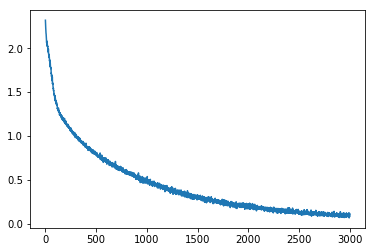

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))